In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import math

In [4]:
tf.__version__

'1.12.0'

https://ireneli.eu/2017/01/17/tensorflow-07-word-embeddings-2-loading-pre-trained-vectors/

In [ ]:
url = "http://nlp.stanford.edu/data/glove.6B.zip"

In [10]:
%%time

# 50차원에 embedding 된 데이터를 로컬에 다운로드해서 로드함.
filename = Path('./embedding/glove.6B.50d.txt')

def load_gloVe(filename):
    vocab = []
    embed = []
    file = open(filename, 'r', encoding='UTF8')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embed.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embed


def load_toy_gloVe(filename):
    vocab = []
    embed = []
    file = open(filename, 'r', encoding='UTF8')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embed.append(row[1:11])
    print('Loaded GloVe!')
    file.close()
    return vocab,embed


vocab, embed = load_toy_gloVe(filename)
vocab_size = len(vocab)

embedding_dim = len(embed[0])
embedding = np.asarray(embed, dtype=np.float64)

Loaded GloVe!
Wall time: 3.55 s


너무 큰 임베딩 차원은 보기에도 불편하고 예제에 부적절하므로,
편의상 임베딩 차원은 10차원으로 한다. (load_toy_gloVe 참조)

아래의 스무 단어를 한 문장이라고 하자. (예를 들어)
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']

문장을 embedding한 결과를 시각화하면 다음과 같다. 세로 축은 문장 길이. 가로 축은 임베딩 차원.
한 줄이 한 단어의 10차원 표현이다.


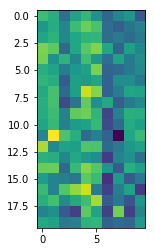

In [94]:
print("너무 큰 임베딩 차원은 보기에도 불편하고 예제에 부적절하므로,")
print("편의상 임베딩 차원은 10차원으로 한다. (load_toy_gloVe 참조)")
d_model = 10
len_sentence = 20

print("\n아래의 스무 단어를 한 문장이라고 하자. (예를 들어)")
print(vocab[:20])

sentence = embedding[:20]
print("\n문장을 embedding한 결과를 시각화하면 다음과 같다. 세로 축은 문장 길이. 가로 축은 임베딩 차원.")
print("한 줄이 한 단어의 {}차원 표현이다.".format(d_model))
plt.imshow(sentence)
plt.show()

RNN 에선 인풋 데이터가 들어가는 순서가 있지만, Attention 모델에서는 입력 순서가 별도로 주어지지 않으므로, 어떤 식으로든 포지션을 인코딩 해야 한다. 차원을 하나 늘여서 포지션을 줘도 되고, 뭘로 해도 되는데 (performance 측면에선 테스트 해 봐야겠지만.) 논문에서는 sin, cos 값을 더해주는 방식으로 진행했다. 논문에서도 다른 방법 써도 된다고 함.

## Positional Encoding
$$  PE(pos,2i) = \sin(pos/10000^{2i/d_{model}}) $$
$$ PE(pos,2i+1) = \cos(pos/10000^{2i/d_{model}}) $$

pos는 위치, i 는 embedding의 차원, d는 모델의 허용 크기

임베딩 결과는 아래와 같다. 세로축이 문장 길이, 가로축이 임베딩 차원.


<Figure size 720x720 with 0 Axes>

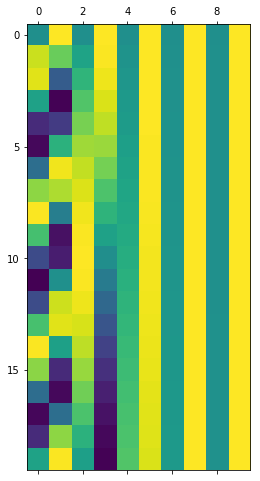

http://jalammar.github.io/illustrated-transformer/ 에서는 아래와 같이 홀 짝을 나눠서 보기 쉽게 표현함.


<Figure size 720x720 with 0 Axes>

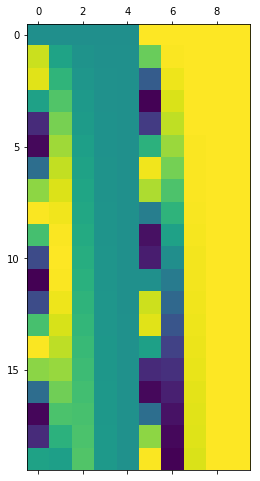

In [96]:
# 짝수 번째는 위 식, 홀수 번째는 위 식으로 포지션 인코딩이 결정되고
# 이 값을 원래 벡터에 더해주면 된다.
pos_enc = np.zeros((len_sentence, d_model))

for pos in range(len_sentence):
    for i in range(int(d_model/2)):
        pos_enc[pos, 2*i] = math.sin(pos / (10000 ** (2*i / d_model)))
        pos_enc[pos, 2*i+1] = math.cos(pos / (10000 ** (2*i / d_model)))
print("임베딩 결과는 아래와 같다. 세로축이 문장 길이, 가로축이 임베딩 차원.")
plt.figure(figsize=(10, 10))
plt.matshow(pos_enc)
plt.show()

print("http://jalammar.github.io/illustrated-transformer/ 에서는 아래와 같이 홀 짝을 나눠서 보기 쉽게 표현함.")

pos_enc_even = pos_enc[:, range(0, d_model, 2)]
pos_enc_odd = pos_enc[:, range(1, d_model, 2)]
pos_enc_visualize = np.hstack([pos_enc_even, pos_enc_odd])

plt.figure(figsize=(10, 10))
plt.matshow(pos_enc_visualize)
plt.show()

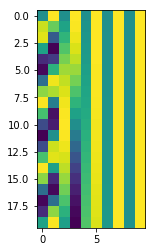

이걸 우리의 문장에 더해주자.
원래 문장은 이랬는데,


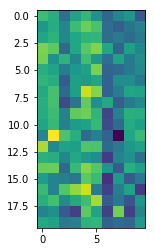

포지션 인코딩이 더해지면서 이렇게 바뀐다.


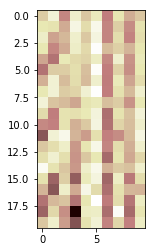

In [105]:
# 위 내용을 함수로 간단히 쓰면 아래와 같다.

def get_pos_enc(d_model, len_sentence):
    pos_enc = np.zeros((len_sentence, d_model))

    for pos in range(len_sentence):
        for i in range(int(d_model/2)):
            pos_enc[pos, 2*i] = math.sin(pos / (10000 ** (2*i / d_model)))
            pos_enc[pos, 2*i+1] = math.cos(pos / (10000 ** (2*i / d_model)))
    return pos_enc

pos_enc = get_pos_enc(d_model, len_sentence)
plt.imshow(pos_enc)
plt.show()

print("이걸 우리의 문장에 더해주자.")
print("원래 문장은 이랬는데,")
plt.imshow(sentence)
plt.show()

print("포지션 인코딩이 더해지면서 이렇게 바뀐다.")
pos_enc_sentence = sentence + pos_enc
plt.imshow(pos_enc_sentence, cmap='pink')
plt.show()